# Wild Life Image Classification
The goal is to classify the species that appear in camera trap images collected by the `DataDriven`'s research partners at the Wild Chimpanzee Foundation and the Max Planck Institute for Evolutionary Anthropology.

In [101]:
# Import Libraries
import os
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from torchinfo import summary

print("Done!")

Done!


In [28]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.5.1
CUDA available: False


In [29]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"The device we shall use is {device}")

The device we shall use is cpu


### Load Data

In [30]:
# Load csv data
train_features = pd.read_csv("train_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id") 
test_features = pd.read_csv("test_features.csv", index_col="id")

In [5]:
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [6]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


We need to have a list of labels in the label data. Which mean this is the species that we shall predict. We put the list in an alphabetic order since that's the way we are geting the submition.

In [31]:
# list animal list
animal_labels = sorted(train_labels.columns.unique())
animal_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [5]:
print("Columns:\n", train_features.columns.to_list())

Columns:
 ['filepath', 'site']


In [10]:
print("Checking the first 5 filepath:\n")
for filepath in train_features["filepath"].head():
    full_path  = os.path.abspath(filepath)
    exists = os.path.exists(full_path)
    print(f"{filepath} -> Exists: {exists}")

Checking the first 5 filepath:

train_features/ZJ000000.jpg -> Exists: True
train_features/ZJ000001.jpg -> Exists: True
train_features/ZJ000002.jpg -> Exists: True
train_features/ZJ000003.jpg -> Exists: True
train_features/ZJ000004.jpg -> Exists: True


### Data Exploration

First let's see the fist 6 images in the train_features dataset.

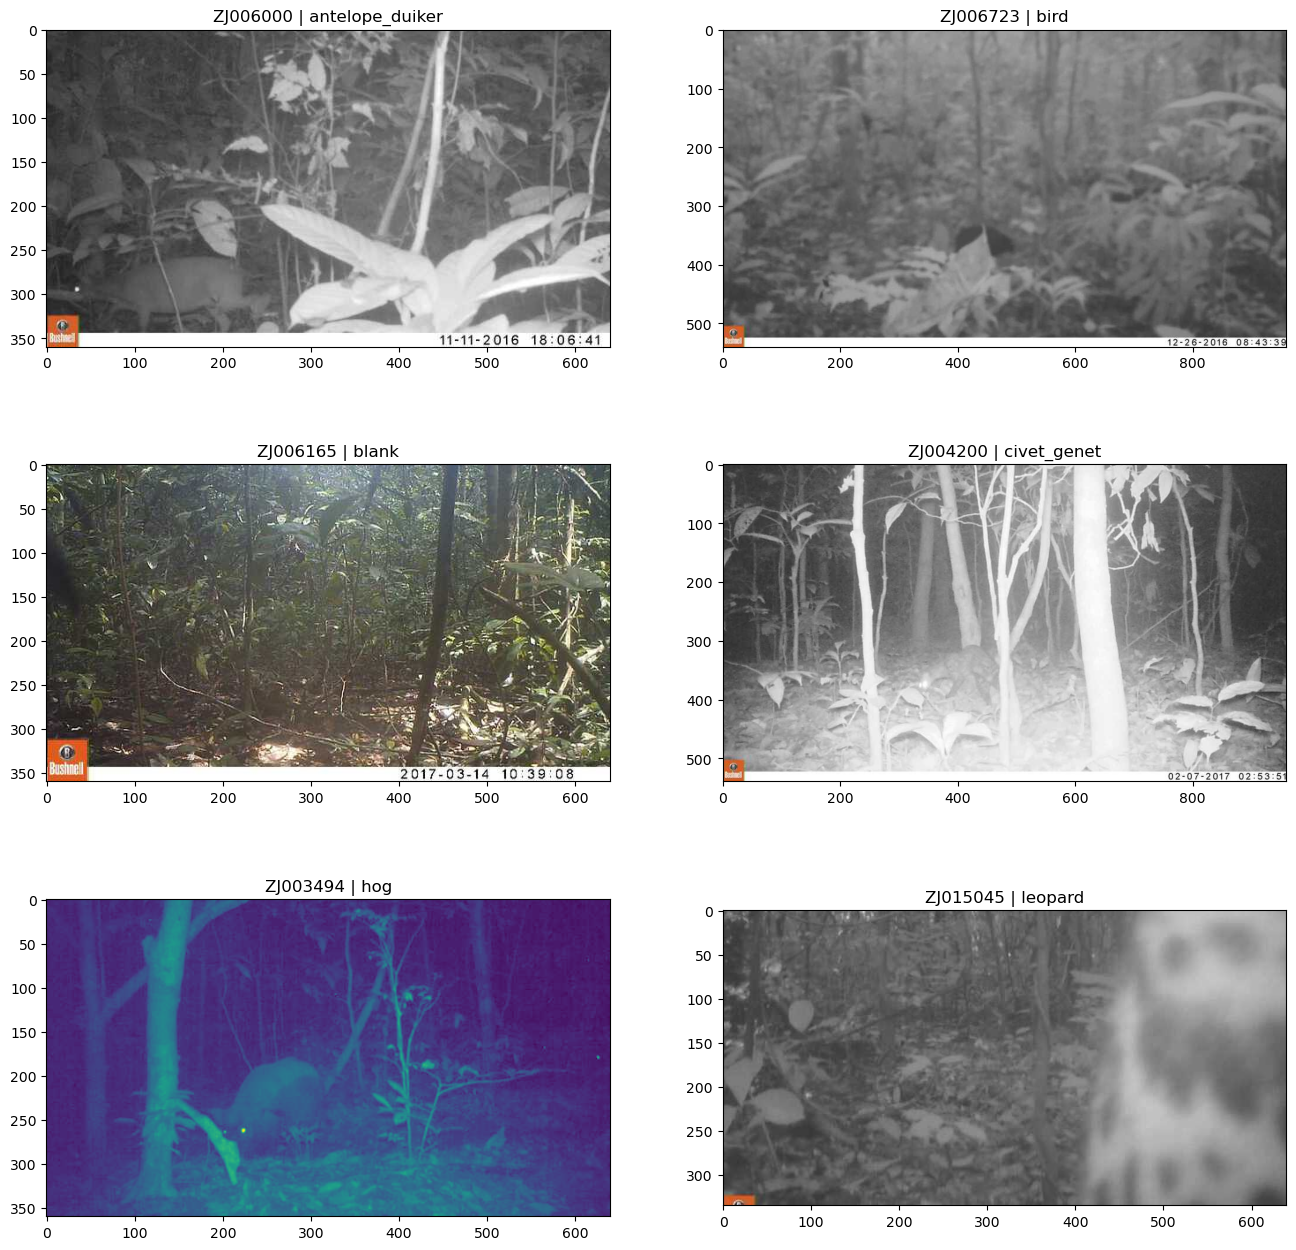

In [32]:
random_state = 42

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for animals, ax in zip(animal_labels, axes.flat):
    # get image id
    im_id = (train_labels[train_labels.loc[:,animals] == 1].sample(1, random_state=random_state).index[0])
    # read filepath and retrun a numpy array
    img = mpimg.imread(train_features.loc[im_id].filepath)
    # plot images
    ax.imshow(img)
    ax.set_title(f"{im_id} | {animals}");

We display the distribution of species in a bar chart. We can see the the monkey has a highest number in the training dataset and the hob be the last.

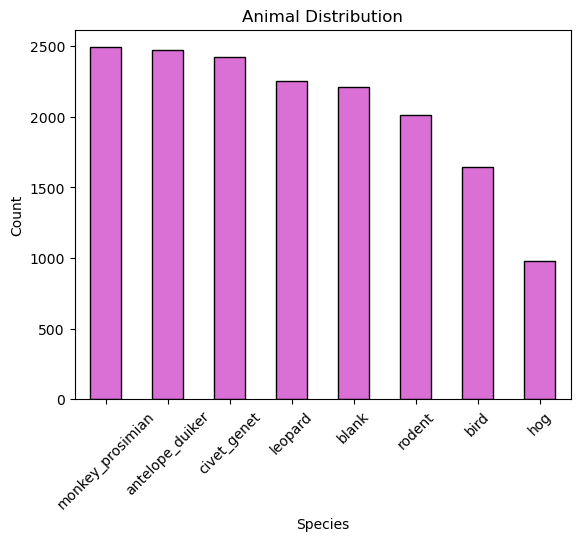

In [33]:
train_labels.sum().sort_values(ascending=False).plot(kind="bar", color="orchid", edgecolor="black")
plt.title("Animal Distribution")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.ylabel("Count");

To work with the training data properly, we need to merge the training features and labels into one dataframe. We use `inner` to style.

In [34]:
# Merge the training set
train_data = pd.merge(train_features, train_labels, on="id", how="inner")
print("Merged train_data shape:", train_data.shape)
print("First 5 rows:")
train_data.head()

Merged train_data shape: (16488, 10)
First 5 rows:


,filepath,site,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,,,
ZJ000000,train_features/ZJ000000.jpg,S0120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,train_features/ZJ000001.jpg,S0069,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,train_features/ZJ000002.jpg,S0009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,train_features/ZJ000003.jpg,S0008,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,train_features/ZJ000004.jpg,S0036,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Distribution of Image Dimension
The goal here is to seen if the dimention between width and height are skewed in order to have an understanding of how much the dimentions are scattered. For later on, we shall have to put all images into a unique dimention to work with. `(224, 244)`

In [35]:
# get image dimension from the image path
img_dims = []
for filepath in train_data["filepath"]:
    full_path = os.path.abspath(filepath)
    with Image.open(full_path) as img:
        width, height = img.size
        img_dims.append((width, height))

In [36]:
# convert the dimension to dataframe for easier interations
dims_df = pd.DataFrame(img_dims, columns=["width", "height"])
dims_df.head()

,width,height
0,960,540
1,960,540
2,640,360
3,640,360
4,640,335


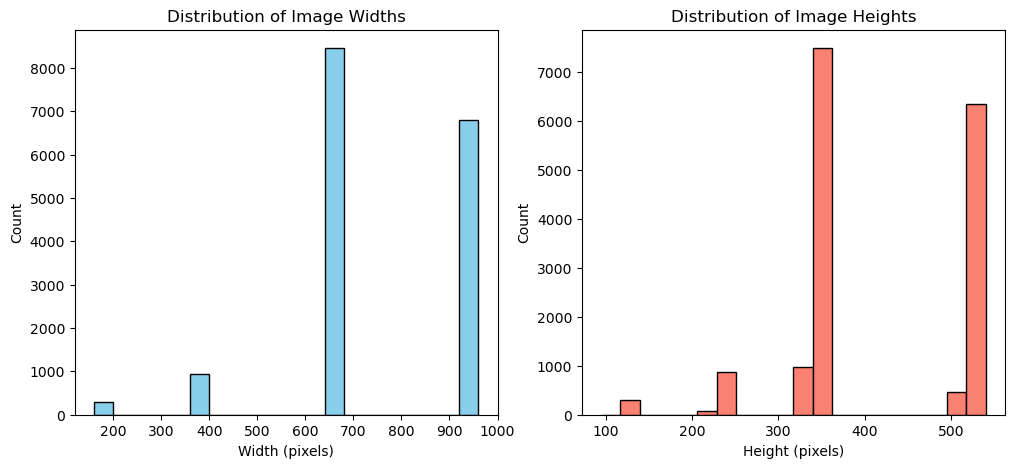

In [37]:
# plot distribution of width and height
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.hist(dims_df["width"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(dims_df["height"], bins=20, color="salmon", edgecolor="black")
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Count");

In [38]:
# unique dimenstion
unique_dims = dims_df.drop_duplicates().sort_values(by=["width", "height"]).reset_index(drop=True)
print("\nUnique image dimension (width, height):")
print(unique_dims)


Unique image dimension (width, height):
   width  height
0    160      95
1    160     120
2    360     215
3    360     240
4    640     335
5    640     360
6    960     515
7    960     540


In [67]:
# reduce the dumber of observation in training and validation data
training_set = train_data[:1000]
validation_set = train_data[1001:1801]
print("Train shape", training_set.shape)
print("Validation shape", validation_set.shape)

Train shape (1000, 10)
Validation shape (800, 10)


##### Convertion To Dataset
This where we transform the images to 224, 224 with and height. Put them into tensor and romalize the data so the the deep learning can go smoothly.

In [43]:
class ConserVisionDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df.copy()
        self.data_df["full_filepath"] = self.data_df["filepath"].apply(os.path.abspath)
        species_columns = [
            'antelope_duiker', 'bird', 'blank', 'civet_genet',
            'hog', 'leopard', 'monkey_prosimian', 'rodent'
        ]
        self.data_df["label_idx"] = self.data_df[species_columns].idxmax(axis=1).map(
            {col: idx for idx, col in enumerate(species_columns)}
        )
        self.label_to_idx = {col: idx for idx, col in enumerate(species_columns)}
        self.idx_to_label = {idx: col for col, idx in self.label_to_idx.items()}
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_path = self.data_df["full_filepath"].iloc[idx]
        image = Image.open(img_path).convert("RGB")  # Convert all modes to RGB
        if self.transform:
            image = self.transform(image)
        label = self.data_df["label_idx"].iloc[idx]
        return image, label

    def get_num_classes(self):
        return len(self.label_to_idx)

    def get_label_map(self):
        return self.idx_to_label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ConserVisionDataset(data_df=training_set, transform=train_transform)

In [68]:
val_dataset = ConserVisionDataset(data_df=validation_set, transform=train_transform)

In [44]:
# test
first_image, first_label = train_dataset[0]
print("First image shape:", first_image.shape)
print("First label index:", first_label)
print("First label name:", train_dataset.get_label_map()[first_label])
print("Number of classes:", train_dataset.get_num_classes())

First image shape: torch.Size([3, 224, 224])
First label index: 1
First label name: bird
Number of classes: 8


We create the data loader of the training set and give it a batch size of 64 and put the num_workers to 0 due to heardware low performance. We are using the CPU.

In [45]:
# create data loader
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False # Since we are not on Cuda
)

We used the resnet18 pretrained model for this training and fine-tune it by giving the last layer  classes because we have 8 species in the training set.

In [46]:
# we use resnet pre-trained model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
# modifly the final fully connected layer
num_classes = train_dataset.get_num_classes()
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# model model to device
model = model.to(device)

# print summary
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 8]                   --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│

In [49]:
# set model to evaluation (no trainig yet)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
# loss function
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss and optimizer set up!")

Loss and optimizer set up!


In [51]:
class ProgressCallback:
    def on_epoch_begin(self, epoch, total_epochs):
        print(f"Starting epoch {epoch+1}/{total_epochs}")
        
    def on_batch_end(self, batch, total_batches, loss, acc=None):
        if batch % 100 == 0:
            msg = f"Batch {batch}/{total_batches} - Loss: {loss:.4f}"
            if acc is not None:
                msg += f" - Acc: {acc:.2f}%"
            print(msg)
            
    def on_epoch_end(self, epoch, total_epochs, epoch_loss, epoch_acc=None):
        msg = f"Finished epoch {epoch+1}/{total_epochs} - Avg Loss: {epoch_loss:.4f}"
        if epoch_acc is not None:
            msg += f" - Avg Acc: {epoch_acc:.2f}%"
        print(msg)

In [52]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=5, callback=None):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        if callback:
            callback.on_epoch_begin(epoch, num_epochs)
            
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if callback:
                batch_acc = 100. * correct / total
                callback.on_batch_end(batch_idx, len(train_loader), loss.item(), batch_acc)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        if callback:
            callback.on_epoch_end(epoch, num_epochs, epoch_loss, epoch_acc)

    return train_losses, train_accuracies

In [53]:
# Run training
callback = ProgressCallback()
num_epochs= 5
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, device, num_epochs, callback=callback)

Starting epoch 1/5
Batch 0/16 - Loss: 2.2343 - Acc: 7.81%
Finished epoch 1/5 - Avg Loss: 1.6790 - Avg Acc: 38.50%
Starting epoch 2/5
Batch 0/16 - Loss: 1.3587 - Acc: 48.44%
Finished epoch 2/5 - Avg Loss: 1.3442 - Avg Acc: 48.30%
Starting epoch 3/5
Batch 0/16 - Loss: 1.0747 - Acc: 56.25%
Finished epoch 3/5 - Avg Loss: 1.0383 - Avg Acc: 63.60%
Starting epoch 4/5
Batch 0/16 - Loss: 1.0407 - Acc: 68.75%
Finished epoch 4/5 - Avg Loss: 0.9479 - Avg Acc: 66.60%
Starting epoch 5/5
Batch 0/16 - Loss: 0.6018 - Acc: 79.69%
Finished epoch 5/5 - Avg Loss: 0.7283 - Avg Acc: 74.20%


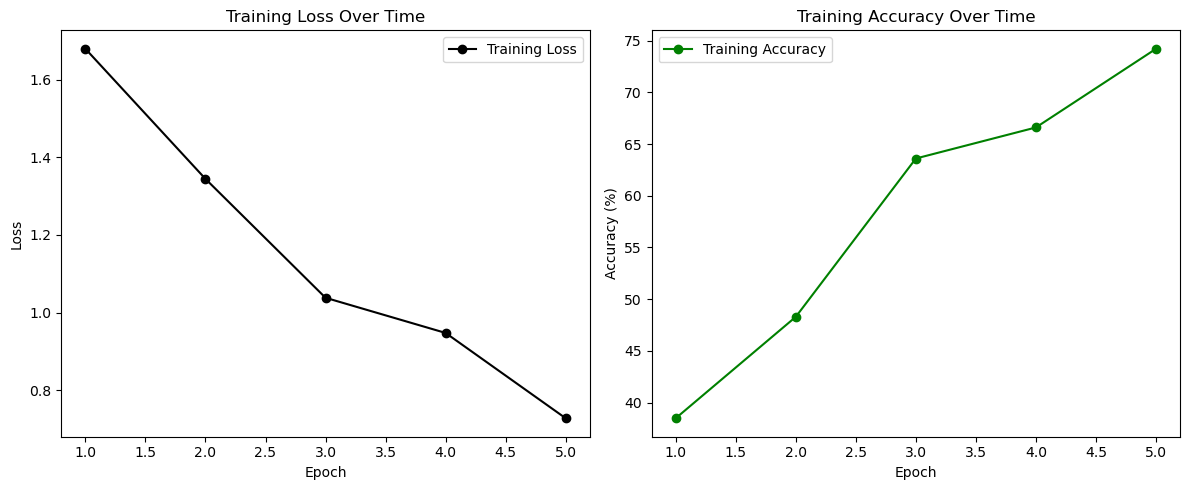

In [59]:
# plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker="o", color="black", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker="o", color="green", label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Time")
plt.legend()

plt.tight_layout()
plt.show()

As you can see in the above viz, the loss and accurary improved in the 5 epochs but we can add more epochs for this. However, for the purpose of this project, we decided to stop at 5 epochs.

###  Model Evaluation

In [60]:
# save model
torch.save(model, "model.pth")

In [61]:
model_loaded = torch.load("model.pth")

C:\Users\Rodri\AppData\Local\Temp\ipykernel_5284\2977631491.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded = torch.load("model.pth")


In [69]:
# create data loader validation set (still batch size 64)
batch_size = 64
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [70]:
print(f"Validation loader: {len(val_loader)} batches")

Validation loader: 13 batches


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3986644..2.64].


Sample label: 2
Sample image shape: torch.Size([3, 224, 224])
blank


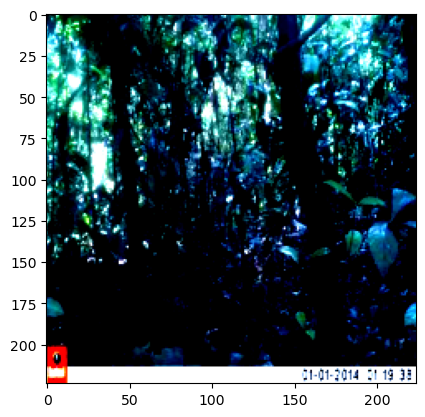

In [78]:
im, lbl = val_dataset[0]
print("Sample label:", lbl)
print("Sample image shape:", im.shape)
print(val_dataset.get_label_map()[lbl])
plt.imshow(im.permute(1, 2, 0));  # Convert to HWC format for display

In [79]:
import torch.nn.functional as F

In [85]:
validation_set.shape

(800, 10)

In [89]:
# Lists for results
all_pred_labels = []
all_true_labels = []
all_pred_probs = []
all_ids = val_dataset.data_df.index.tolist()  # Use index for 'id'
all_filepaths = val_dataset.data_df["filepath"].tolist()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_loaded(images)
        _, predicted = torch.max(outputs, 1)
        all_pred_labels.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())
        probs = F.softmax(outputs, dim=1)
        all_pred_probs.extend(probs.cpu().numpy())

# Map to class names
class_names = val_dataset.get_label_map()  # {0: 'antelope_duiker', ...}
pred_class_names = [class_names[p] for p in all_pred_labels]
true_class_names = [class_names[t] for t in all_true_labels]

In [90]:
# Create DataFrame
val_predictions = pd.DataFrame({
    "id": all_ids,
    "filepath": all_filepaths,
    "predicted_label": all_pred_labels,
    "predicted_class": pred_class_names,
    "true_label": all_true_labels,
    "true_class": true_class_names
})
for i in range(8):
    val_predictions[f"prob_{class_names[i]}"] = [p[i] for p in all_pred_probs]

In [91]:
# Evaluate
correct = sum(p == t for p, t in zip(all_pred_labels, all_true_labels))
val_accuracy = 100. * correct / len(all_true_labels)
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Validation Accuracy: 61.75%


In [92]:
val_loss = 0.0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_loaded(images)
        val_loss += criterion(outputs, labels).item() * images.size(0)
val_loss /= len(val_dataset)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 1.2787


With the validation accuracy beight `61.75%` and validation loss `1.2787`. compared to the training accuracy and loss. This means that the model start learning well by undertanding the parten in the data but it is not quite good at generalizing.

In [93]:
# Save
print("Sample predictions:")
print(val_predictions.head())
val_predictions.to_csv("val_predictions_with_labels.csv", index=False)
print("Predictions saved to 'val_predictions_with_labels.csv'")

Sample predictions:
         id                     filepath  predicted_label   predicted_class  \
0  ZJ001001  train_features/ZJ001001.jpg                6  monkey_prosimian   
1  ZJ001002  train_features/ZJ001002.jpg                1              bird   
2  ZJ001003  train_features/ZJ001003.jpg                4               hog   
3  ZJ001004  train_features/ZJ001004.jpg                2             blank   
4  ZJ001005  train_features/ZJ001005.jpg                6  monkey_prosimian   

   true_label        true_class  prob_antelope_duiker  prob_bird  prob_blank  \
0           2             blank              0.083203   0.046528    0.005430   
1           7            rodent              0.029368   0.423739    0.065714   
2           4               hog              0.031094   0.000689    0.021511   
3           2             blank              0.168890   0.085928    0.359072   
4           6  monkey_prosimian              0.064763   0.006987    0.001488   

   prob_civet_genet  pro

In [94]:
print("Predicted Class Distribution:")
print(val_predictions["predicted_class"].value_counts())

Predicted Class Distribution:
predicted_class
monkey_prosimian    131
antelope_duiker     125
blank               110
civet_genet         107
leopard             103
rodent               96
bird                 90
hog                  38
Name: count, dtype: int64


In [95]:
print("True Class Distribution:")
print(val_predictions["true_class"].value_counts())

True Class Distribution:
true_class
civet_genet         123
monkey_prosimian    122
leopard             115
rodent              110
antelope_duiker     106
blank                89
bird                 85
hog                  50
Name: count, dtype: int64


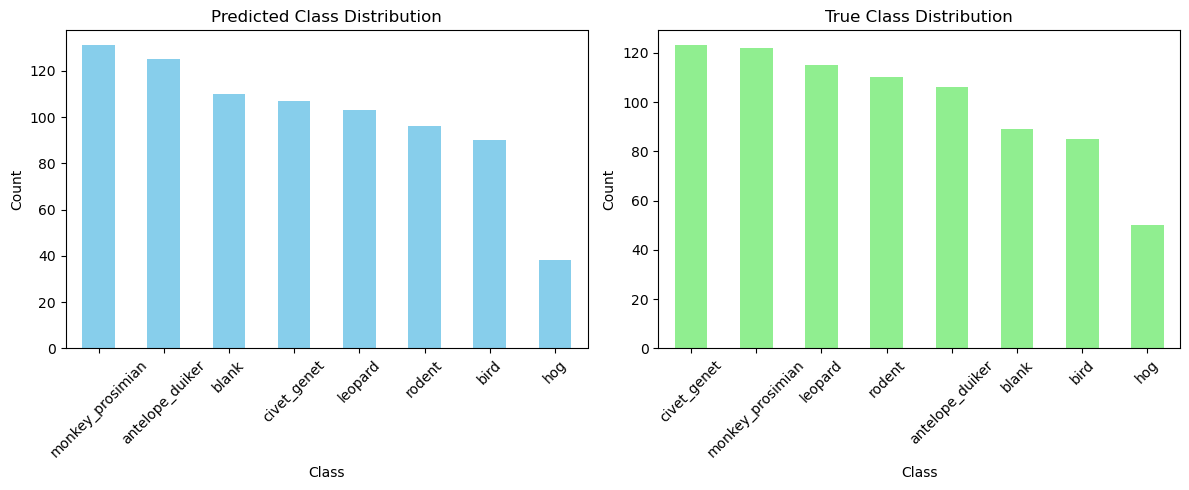

In [96]:
# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
val_predictions["predicted_class"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
val_predictions["true_class"].value_counts().plot(kind="bar", color="lightgreen")
plt.title("True Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [98]:
# Recompute batch-wise validation loss
criterion = torch.nn.CrossEntropyLoss(reduction='none')  # Per-sample loss
batch_losses = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model_loaded(images)
        loss = criterion(outputs, labels)  # Loss per sample
        batch_avg_loss = loss.mean().item()  # Average for this batch
        batch_losses.append(batch_avg_loss)
        print(f"Batch {batch_idx+1}/{len(val_loader)}, Loss: {batch_avg_loss:.4f}")

Batch 1/13, Loss: 1.3635
Batch 2/13, Loss: 1.3047
Batch 3/13, Loss: 1.1356
Batch 4/13, Loss: 1.0789
Batch 5/13, Loss: 1.2199
Batch 6/13, Loss: 1.2005
Batch 7/13, Loss: 1.7561
Batch 8/13, Loss: 1.6330
Batch 9/13, Loss: 1.2597
Batch 10/13, Loss: 1.4841
Batch 11/13, Loss: 0.9894
Batch 12/13, Loss: 0.9829
Batch 13/13, Loss: 1.1500


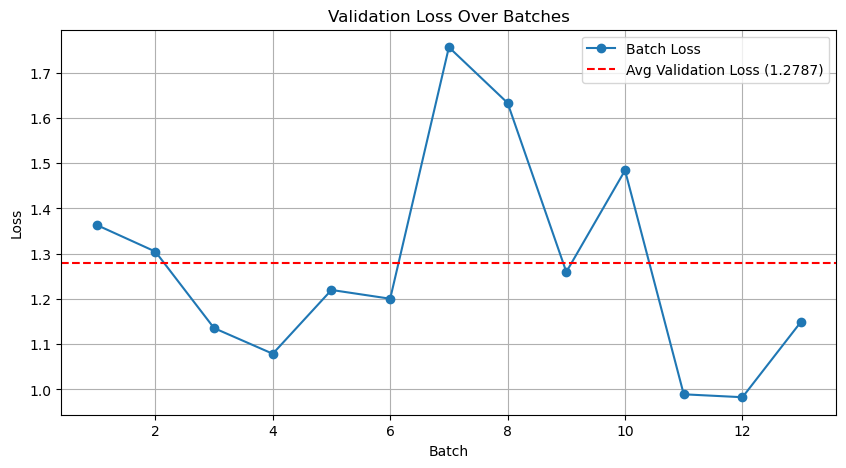

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(batch_losses) + 1), batch_losses, marker='o', label="Batch Loss")
plt.axhline(y=1.2787, color='r', linestyle='--', label="Avg Validation Loss (1.2787)")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Validation Loss Over Batches")
plt.legend()
plt.grid(True)
plt.show()

The above line graph shows there are ouliers in the model because of the __batch loss__ spining at 7 -8 and 11. But this is not too much to consider. Training with 8 epochs would definetly stabilize the loss.

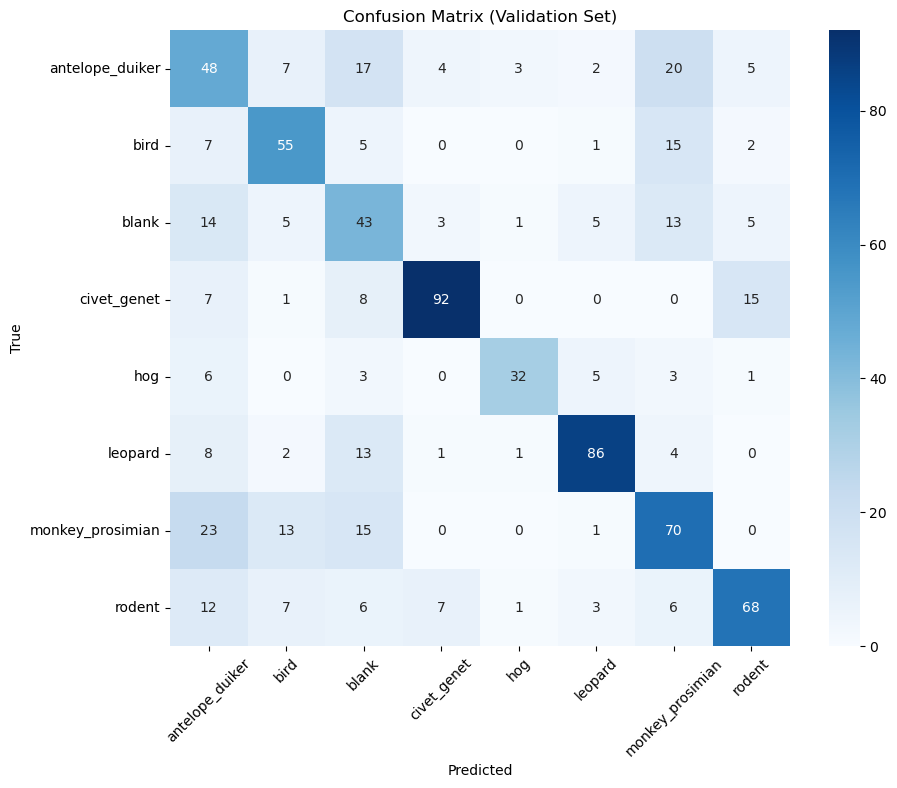

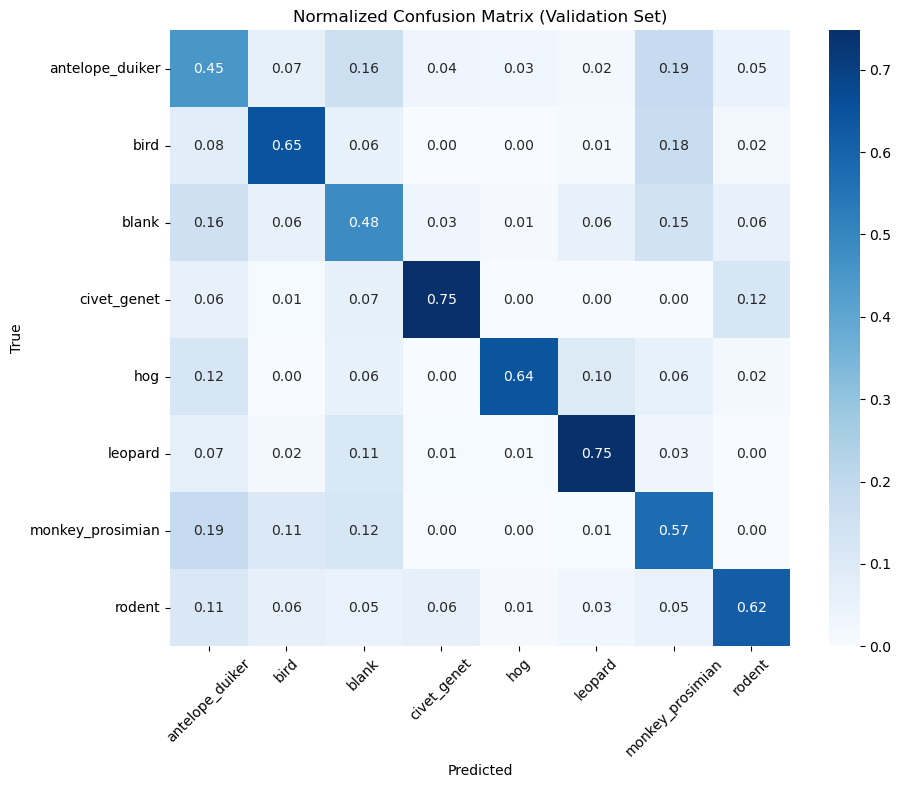

In [102]:
# Confusion Matrix
cm = confusion_matrix(val_predictions["true_label"], val_predictions["predicted_label"])
class_names = val_dataset.get_label_map().values()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation Set)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Validation Set)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

#### Submition
We shall submit the prediction in a csv file based on the competion requirement. The id plus the prediction of each species.

In [114]:
validation_set.head()

,filepath,site,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,,,
ZJ001001,train_features/ZJ001001.jpg,S0157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ001002,train_features/ZJ001002.jpg,S0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ZJ001003,train_features/ZJ001003.jpg,S0170,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ZJ001004,train_features/ZJ001004.jpg,S0106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ001005,train_features/ZJ001005.jpg,S0002,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [105]:
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


Since the test data does not have the same amount of columns as the trainig set. We shall have to define a specific dataset conversion for it. But the transfroma will remain the same.

In [106]:
# Define test specific dataset
class TestConserVisionDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.filepaths = data_df["filepath"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# The same transform as in the training and validation (awesome)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [107]:
test_dataset = TestConserVisionDataset(data_df=test_features, transform=train_transform)

In [108]:
# test loader same batch size
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Keep order for submission
    num_workers=0,
    pin_memory=False
)
print("Test batches:", len(test_loader))

Test batches: 70


In [109]:
model_loaded.eval()  # Set model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [117]:
# List for probabilities
all_pred_probs = []
all_ids = test_features.index.tolist()

# Inference
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model_loaded(images)
        probs = F.softmax(outputs, dim=1)
        all_pred_probs.extend(probs.cpu().numpy())

In [131]:
# Class names
class_names = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 
               'hog', 'leopard', 'monkey_prosimian', 'rodent']

# Create DataFrame with probabilities
submission_df = pd.DataFrame(
    data=all_pred_probs,
    index=all_ids,
    columns=class_names
)

submission_df.index.name = "id"
submission_df.reset_index(inplace=True)

print("Sample submission:")
submission_df.head()

Sample submission:


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,0.079009,0.004384,0.658267,0.007305,0.030133,0.208485,0.000820,0.011597
1,ZJ016489,0.579921,0.100268,0.015793,0.006411,0.199386,0.004473,0.071725,0.022021
2,ZJ016490,0.535013,0.001892,0.012616,0.367427,0.057749,0.002705,0.001055,0.021543
3,ZJ016491,0.000345,0.000031,0.019722,0.000387,0.000745,0.977921,0.000032,0.000817
4,ZJ016492,0.231730,0.565960,0.005468,0.001548,0.035838,0.001205,0.154546,0.003706


In [112]:
df = pd.read_csv("submission_format.csv", index_col="id")
df.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ016488,0.048233,0.189185,0.044914,0.199588,0.106118,0.132915,0.166410,0.112637
ZJ016489,0.097078,0.061400,0.026409,0.241530,0.144344,0.051780,0.287811,0.089648
ZJ016490,0.124658,0.089101,0.189225,0.174494,0.180540,0.079995,0.085672,0.076314
ZJ016491,0.109966,0.048397,0.055598,0.323600,0.322356,0.063252,0.008160,0.068671
ZJ016492,0.165742,0.184610,0.005431,0.136806,0.000389,0.122078,0.151521,0.233423


In [144]:
# save
submission_df.to_csv("submission.csv", index=False, index_label="id")
print("Submission saved to 'submission.csv'")

Submission saved to 'submission.csv'


In [140]:
submission_df.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,0.079009,0.004384,0.658267,0.007305,0.030133,0.208485,0.000820,0.011597
1,ZJ016489,0.579921,0.100268,0.015793,0.006411,0.199386,0.004473,0.071725,0.022021
2,ZJ016490,0.535013,0.001892,0.012616,0.367427,0.057749,0.002705,0.001055,0.021543
3,ZJ016491,0.000345,0.000031,0.019722,0.000387,0.000745,0.977921,0.000032,0.000817
4,ZJ016492,0.231730,0.565960,0.005468,0.001548,0.035838,0.001205,0.154546,0.003706


In [146]:
load_submition = pd.read_csv("submission.csv", index_col="id")
load_submition

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ016488,0.079009,0.004384,0.658267,0.007305,0.030133,0.208485,0.000820,0.011597
ZJ016489,0.579921,0.100268,0.015793,0.006411,0.199386,0.004473,0.071725,0.022021
ZJ016490,0.535013,0.001892,0.012616,0.367427,0.057749,0.002705,0.001055,0.021543
ZJ016491,0.000345,0.000031,0.019722,0.000387,0.000745,0.977921,0.000032,0.000817
ZJ016492,0.231730,0.565960,0.005468,0.001548,0.035838,0.001205,0.154546,0.003706
...,...,...,...,...,...,...,...,...
ZJ020947,0.189253,0.030617,0.486523,0.000607,0.011189,0.013915,0.247153,0.020742
ZJ020948,0.022943,0.183824,0.222894,0.002079,0.030734,0.522796,0.005633,0.009097
ZJ020949,0.025632,0.002350,0.471924,0.156202,0.072041,0.092831,0.000866,0.178154


In [147]:
load_submition.to_csv("submission.csv")
print("Save the ffinal submission file as 'submission.csv'")

Save the ffinal submission file as 'submission.csv'


In [148]:
sub_df = pd.read_csv("submission.csv", index_col="id")
sub_df.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ016488,0.079009,0.004384,0.658267,0.007305,0.030133,0.208485,0.000820,0.011597
ZJ016489,0.579921,0.100268,0.015793,0.006411,0.199386,0.004473,0.071725,0.022021
ZJ016490,0.535013,0.001892,0.012616,0.367427,0.057749,0.002705,0.001055,0.021543
ZJ016491,0.000345,0.000031,0.019722,0.000387,0.000745,0.977921,0.000032,0.000817
ZJ016492,0.231730,0.565960,0.005468,0.001548,0.035838,0.001205,0.154546,0.003706


In [ ]:
# check if the submission file is correct with the format
assert all(df.index == sub_df.index), "Index values do not match!"
assert all(df.columns == sub_df.columns), "Column names do not match!"

print("The submission file is ready for submission!")

The submission file is ready for submission!
